In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import sqlite3

In [4]:
# monta o google drive corretamente
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
# verificar o database
import os

path = "/content/drive/MyDrive/"
for file in os.listdir(path):
    if file.endswith(".db"):
        print(file)



data_japan.db


In [7]:
# conectar ao banco SQLite
conn = sqlite3.connect('/content/drive/MyDrive/data_japan.db')
cur = conn.cursor()

In [9]:
# Carregar planilhas
from google.colab import files
uploaded = files.upload()



Saving labour_force_2020.csv to labour_force_2020.csv
Saving worker by prefecture 2023.csv to worker by prefecture 2023.csv


In [11]:
# cria tabelas no pandas
df_labour_2020 = pd.read_csv('labour_force_2020.csv')
df_worker_2023 = pd.read_csv('worker by prefecture 2023.csv')

In [14]:
# cria tabelas no sql
df_labour_2020.to_sql('labour', conn, index=False, if_exists='replace')
df_worker_2023.to_sql('worker', conn, index=False, if_exists='replace')

48

## Explanatory Analysis
###Labor Conditions by Region


Tools: SQL (aggregations) | Python (data wrangling and visualizations) | Tableau (gender-based wage comparison map)

In [15]:
df_worker_2023.head()

,Prefecture,monthly_worked_hours_m,monthly_worked_hours_f,pt_hourly_salary_m,pt_hourly_salary_f,number_pt_workers_m,number_pt_workers_f,hs_graduated_salary_m,hs_graduated_salary_f
0,All Japan,182,171,1657,1312,3620560,8890370,189000,183200
1,Hokkaido,182,170,1424,1163,127980,378250,175900,171700
2,Aomori,182,169,1416,1090,19580,58340,177400,164700
3,Iwate,181,171,1433,1198,18220,55660,180900,178000
4,Miyagi,182,168,1259,1167,53750,136770,188000,178900



1. Top 5 regions with the highest salary for men and women.

In [29]:
# Top 5 prefectures with highest salary Men
pd.read_sql('''
                SELECT Prefecture, pt_hourly_salary_m
                FROM worker
                ORDER BY pt_hourly_salary_m desc
                LIMIT 5;
''', conn)

,Prefecture,pt_hourly_salary_m
0,Kochi,2136
1,Hyogo,2115
2,Kanagawa,2045
3,Chiba,1839
4,Kyoto,1817


In [32]:
# Top 5 prefectures with highest salary women

pd.read_sql('''
                SELECT prefecture,
                pt_hourly_salary_f
                FROM worker
                ORDER BY pt_hourly_salary_f desc
                LIMIT 5;

''',conn)

,Prefecture,pt_hourly_salary_f
0,Tokyo,1534
1,Hyogo,1461
2,Kyoto,1419
3,Kanagawa,1409
4,Hiroshima,1389



2. Which regions show the highest gender pay gap?

In [35]:
# Calculate Gender Pay Gap
pd.read_sql('''
              SELECT Prefecture,
                     pt_hourly_salary_m - pt_hourly_salary_f	as gender_gap
              FROM worker
              ORDER BY gender_gap desc
              LIMIT 5
            ''', conn)

,Prefecture,gender_gap
0,Kochi,957
1,Hyogo,654
2,Kanagawa,636
3,Ibaraki,584
4,Oita,582




3. Where do people work the most hours per month on average?

In [80]:
# Top 5 Prefectures where men work the most hours per month
pd.read_sql('''
                SELECT Prefecture,
                monthly_worked_hours_m
                FROM worker
                ORDER BY monthly_worked_hours_m desc
                LIMIT 5;

''',conn)

,Prefecture,monthly_worked_hours_m
0,Saitama,186
1,Tochigi,185
2,Kagawa,185
3,Saga,184
4,Nagasaki,184


In [78]:
# Top 5 Prefectures where women work the most hours per month
pd.read_sql('''
                SELECT Prefecture,
                       monthly_worked_hours_f
                FROM worker
                ORDER BY monthly_worked_hours_f desc
                LIMIT 5;

''',conn)

,Prefecture,monthly_worked_hours_f
0,Tochigi,172
1,Gunma,172
2,Tokyo,172
3,Toyama,172
4,Yamanashi,172


4. Where do people work the less hours per week on average?



In [82]:
# Top 5 Prefectures where men work less hours per week
pd.read_sql('''
                SELECT Prefecture,
                ROUND(monthly_worked_hours_m/4.2, 2)as weekly_worked_hour_m
                FROM worker
                ORDER BY weekly_worked_hour_m asc
                LIMIT 5;

''',conn)

,Prefecture,weekly_worked_hour_m
0,Kochi,41.90
1,Tottori,42.14
2,Okinawa,42.38
3,Akita,42.62
4,Ibaraki,42.62


In [83]:
# Top 5 Prefectures where women work less hours per week

pd.read_sql('''
                SELECT Prefecture,
                ROUND(monthly_worked_hours_f/4.2, 2)as weekly_worked_hour_f
                FROM worker
                ORDER BY weekly_worked_hour_f asc
                LIMIT 5;

''',conn)

,Prefecture,weekly_worked_hour_f
0,Chiba,39.76
1,Shiga,39.76
2,Kyoto,39.76
3,Oita,39.76
4,Miyagi,40.00


/tmp/ipython-input-74-3532143301.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_worker_2023.sort_values(by='gender_gap', ascending=False),


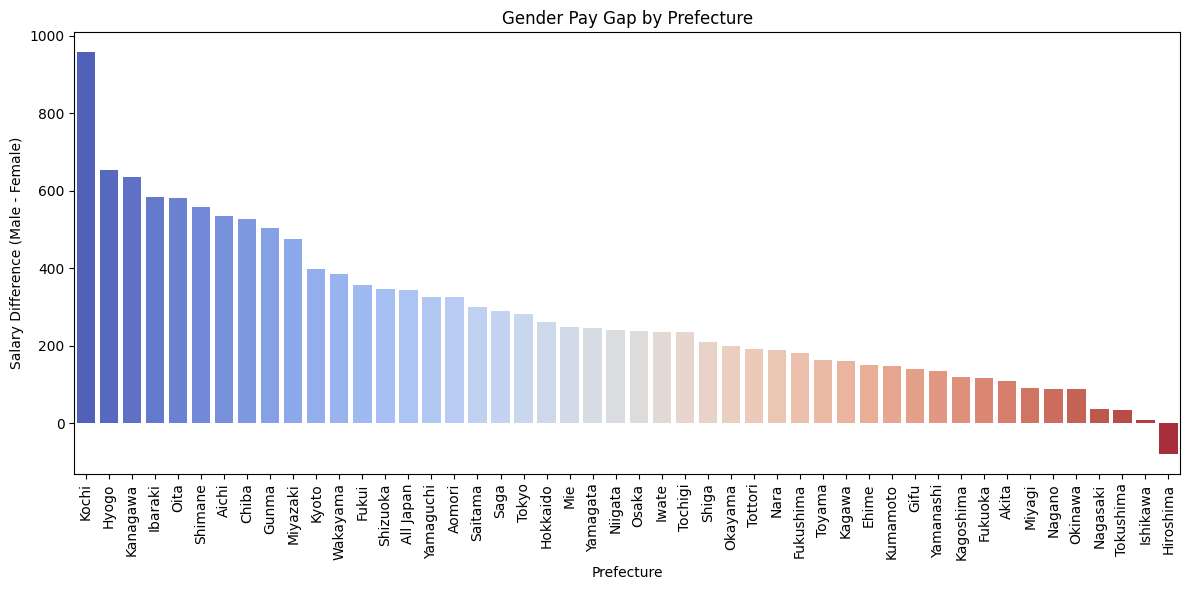

In [74]:
plt.figure(figsize=(12,6))
sns.barplot(data=df_worker_2023.sort_values(by='gender_gap', ascending=False),
            x='Prefecture', y='gender_gap', palette='coolwarm')
plt.xticks(rotation=90)
plt.title('Gender Pay Gap by Prefecture')
plt.ylabel('Salary Difference (Male - Female)')
plt.tight_layout()
plt.show()
